In [132]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/german-data/deu.txt
/kaggle/input/data-files/glove.6B.100d.txt
/kaggle/input/data-files/hin.txt


In [133]:
from __future__ import print_function,division
from builtins import range,input

In [134]:
import sys,os,pandas as pd,numpy as np,matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input,LSTM,Dense,Embedding,Bidirectional,RepeatVector,Concatenate,\
    Activation,Dot,Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.activations import softmax
from keras.optimizers import RMSprop,Adam,SGD
from keras.models import load_model
import keras

In [135]:
#applying softmax over time axis
#the dimension is N*T*D, so we will use axis 1 as axis 1 is time axis
def softmax_over_time(x):
    #assert(k.ndim(x)>2)
    return softmax(x,axis =1)
def selu(x):
    return keras.activations.selu(x)
    

In [136]:
#config parameters
LATENT_DIM_DECODER = 400
BATCH_SIZE =64
EPOCHS = 150
LATENT_DIM = 400
NUM_SAMPLES = 10000
MAX_SEQUENCE_LEN = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [137]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1


# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('/kaggle/input/german-data/deu.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))


num samples: 10000


In [138]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


Found 2240 unique input tokens.
Found 4979 unique output tokens.


In [139]:
#PADDING 

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')


encoder_data.shape: (10000, 5)
encoder_data[0]: [ 0  0  0  0 13]
decoder_data[0]: [   2 1540    0    0    0    0    0    0    0    0]
decoder_data.shape: (10000, 10)


In [140]:
#LOADING PRETRAINED WORD VECTORS
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/kaggle/input/data-files/glove.6B.100d.txt')) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [141]:
#EMBEDDING MATRIX
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [142]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  trainable=False
)


In [143]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word > 0:
      decoder_targets_one_hot[i, t, word] = 1


In [144]:
#building the model

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  recurrent_dropout = 0.35 # dropout not available on gpu
))
encoder_outputs = encoder(x)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)




######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context


# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True , recurrent_dropout = 0.35)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)


# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c


In [145]:
# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)


# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D



In [146]:
def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)


In [147]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)


In [148]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total
def ppl_e(y_true, y_pred):
    return K.exp(K.mean(K.categorical_crossentropy(y_true, y_pred)))

opt = Adam(lr=0.0001)
#COMPILING THE MODEL
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 5, 100)       224100      input_13[0][0]                   
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 400)          0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 5, 800)       1603200     embedding_13[0][0]               
____________________________________________________________________________________________

In [149]:
#TRAIN THE MODEL
#implementing callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
checkpoint = ModelCheckpoint("englisg_german.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)
early_stopping = EarlyStopping(monitor="val_loss",
                              min_delta=0,
                              patience=10,
                              verbose=1,
                              restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                             factor=0.1,
                             patience=3,
                             verbose=1,
                             min_delta=0.0001)
#putting callbacks in callbacks list
callbacks = [checkpoint,early_stopping,reduce_lr]
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2 , callbacks= callbacks
)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/150
8000/8000 [==============================] - 18s 2ms/step - loss: 2.8606 - accuracy: 0.0975 - val_loss: 2.6060 - val_accuracy: 0.1007

Epoch 00001: val_loss improved from inf to 2.60604, saving model to englisg_german.h5
Epoch 2/150
8000/8000 [==============================] - 9s 1ms/step - loss: 2.2323 - accuracy: 0.1251 - val_loss: 2.4804 - val_accuracy: 0.1044

Epoch 00002: val_loss improved from 2.60604 to 2.48035, saving model to englisg_german.h5
Epoch 3/150
8000/8000 [==============================] - 9s 1ms/step - loss: 2.1274 - accuracy: 0.1290 - val_loss: 2.4181 - val_accuracy: 0.1225

Epoch 00003: val_loss improved from 2.48035 to 2.41807, saving model to englisg_german.h5
Epoch 4/150
8000/8000 [==============================] - 9s 1ms/step - loss: 2.0764 - accuracy: 0.1348 - val_loss: 2.3876 - val_accuracy: 0.1248

Epoch 00004: val_loss improved from 2.41807 to 2.38761, saving model to englisg_german.h5
Epoch 5/150

8000/8000 [==============================] - 9s 1ms/step - loss: 1.2314 - accuracy: 0.2081 - val_loss: 1.8499 - val_accuracy: 0.2028

Epoch 00035: val_loss improved from 1.85731 to 1.84991, saving model to englisg_german.h5
Epoch 36/150
8000/8000 [==============================] - 9s 1ms/step - loss: 1.2120 - accuracy: 0.2103 - val_loss: 1.8397 - val_accuracy: 0.2079

Epoch 00036: val_loss improved from 1.84991 to 1.83970, saving model to englisg_german.h5
Epoch 37/150
8000/8000 [==============================] - 9s 1ms/step - loss: 1.1932 - accuracy: 0.2121 - val_loss: 1.8359 - val_accuracy: 0.2074

Epoch 00037: val_loss improved from 1.83970 to 1.83590, saving model to englisg_german.h5
Epoch 38/150
8000/8000 [==============================] - 9s 1ms/step - loss: 1.1746 - accuracy: 0.2142 - val_loss: 1.8301 - val_accuracy: 0.2098

Epoch 00038: val_loss improved from 1.83590 to 1.83009, saving model to englisg_german.h5
Epoch 39/150
8000/8000 [==============================] - 10s 1ms


Epoch 00069: val_loss improved from 1.70625 to 1.70458, saving model to englisg_german.h5
Epoch 70/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.7013 - accuracy: 0.2750 - val_loss: 1.7025 - val_accuracy: 0.2340

Epoch 00070: val_loss improved from 1.70458 to 1.70248, saving model to englisg_german.h5
Epoch 71/150
8000/8000 [==============================] - 10s 1ms/step - loss: 0.6897 - accuracy: 0.2772 - val_loss: 1.6979 - val_accuracy: 0.2345

Epoch 00071: val_loss improved from 1.70248 to 1.69787, saving model to englisg_german.h5
Epoch 72/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.6788 - accuracy: 0.2796 - val_loss: 1.6978 - val_accuracy: 0.2342

Epoch 00072: val_loss improved from 1.69787 to 1.69776, saving model to englisg_german.h5
Epoch 73/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.6675 - accuracy: 0.2818 - val_loss: 1.6945 - val_accuracy: 0.2349

Epoch 00073: val_loss improved from 1.69776 to 1.6


Epoch 00105: val_loss did not improve from 1.65463
Epoch 106/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.3950 - accuracy: 0.3367 - val_loss: 1.6537 - val_accuracy: 0.2462

Epoch 00106: val_loss improved from 1.65463 to 1.65370, saving model to englisg_german.h5
Epoch 107/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.3890 - accuracy: 0.3377 - val_loss: 1.6561 - val_accuracy: 0.2456

Epoch 00107: val_loss did not improve from 1.65370
Epoch 108/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.3830 - accuracy: 0.3392 - val_loss: 1.6559 - val_accuracy: 0.2465

Epoch 00108: val_loss did not improve from 1.65370
Epoch 109/150
8000/8000 [==============================] - 9s 1ms/step - loss: 0.3775 - accuracy: 0.3403 - val_loss: 1.6546 - val_accuracy: 0.2472

Epoch 00109: val_loss did not improve from 1.65370

Epoch 00109: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 110/150
8000/8000 [=======

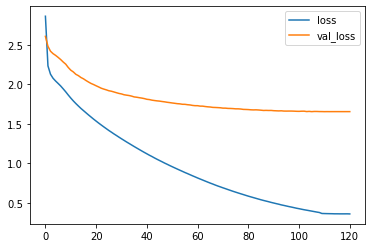

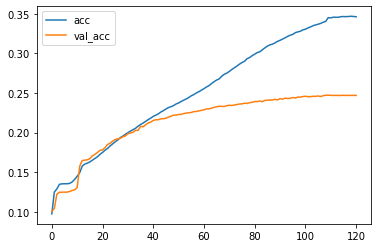

In [150]:
# plotting the accuracies
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [151]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])




# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D

In [152]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


In [153]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [154]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)



In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break


-
Input sentence: Boil one egg.
Predicted translation: kochen sie ein ei!
Actual translation: Kochen Sie ein Ei! <eos>
Continue? [Y/n]Y
-
Input sentence: I hate this.
Predicted translation: ich hasse die.
Actual translation: Ich hasse das. <eos>
Continue? [Y/n]Y
-
Input sentence: We had fun.
Predicted translation: wir hatten unseren spaß.
Actual translation: Wir hatten unseren Spaß. <eos>
